# Лабораторна робота №2: Логістична регресія

## Мета
Реалізувати модель логістичної регресії "з нуля" для класифікації результатів медичних тестів на основі даних про пацієнтів.

## Завдання
Дослідити вплив різних методів оптимізації та регуляризації на якість моделі.

**Датасет**: Healthcare Dataset  
**Цільова змінна**: Test Results (Normal/Abnormal - бінарна класифікація)  
**Методи**: SGD та Mini-batch градієнтний спуск

## 1. Імпорт бібліотек та підготовка даних

In [26]:
# Імпорт необхідних бібліотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Налаштування візуалізації
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

pd.set_option('display.max_columns', None)
np.set_printoptions(precision=4, suppress=True)

print("✅ Всі бібліотеки успішно імпортовані!")

✅ Всі бібліотеки успішно імпортовані!


In [27]:
# Завантаження даних
df = pd.read_csv('healthcare_dataset.csv')

print("=" * 70)
print("ОГЛЯД ДАНИХ")
print("=" * 70)
print(f"\nРозмір датасету: {df.shape[0]} рядків, {df.shape[1]} стовпців\n")

print("Перші 5 рядків:")
print(df.head())

print("\n" + "=" * 70)
print("ІНФОРМАЦІЯ ПРО ДАНІ")
print("=" * 70)
df.info()

ОГЛЯД ДАНИХ

Розмір датасету: 55500 рядків, 15 стовпців

Перші 5 рядків:
            Name  Age  Gender Blood Type Medical Condition Date of Admission  \
0  Bobby JacksOn   30    Male         B-            Cancer        2024-01-31   
1   LesLie TErRy   62    Male         A+           Obesity        2019-08-20   
2    DaNnY sMitH   76  Female         A-           Obesity        2022-09-22   
3   andrEw waTtS   28  Female         O+          Diabetes        2020-11-18   
4  adrIENNE bEll   43  Female        AB+            Cancer        2022-09-19   

             Doctor                    Hospital Insurance Provider  \
0     Matthew Smith             Sons and Miller         Blue Cross   
1   Samantha Davies                     Kim Inc           Medicare   
2  Tiffany Mitchell                    Cook PLC              Aetna   
3       Kevin Wells  Hernandez Rogers and Vang,           Medicare   
4    Kathleen Hanna                 White-White              Aetna   

   Billing Amount  Room N

АНАЛІЗ ЦІЛЬОВОЇ ЗМІННОЇ (Test Results)

Розподіл класів:
Test Results
Abnormal        18627
Normal          18517
Inconclusive    18356
Name: count, dtype: int64

Відсоткове співвідношення:
Test Results
Abnormal        33.562162
Normal          33.363964
Inconclusive    33.073874
Name: proportion, dtype: float64


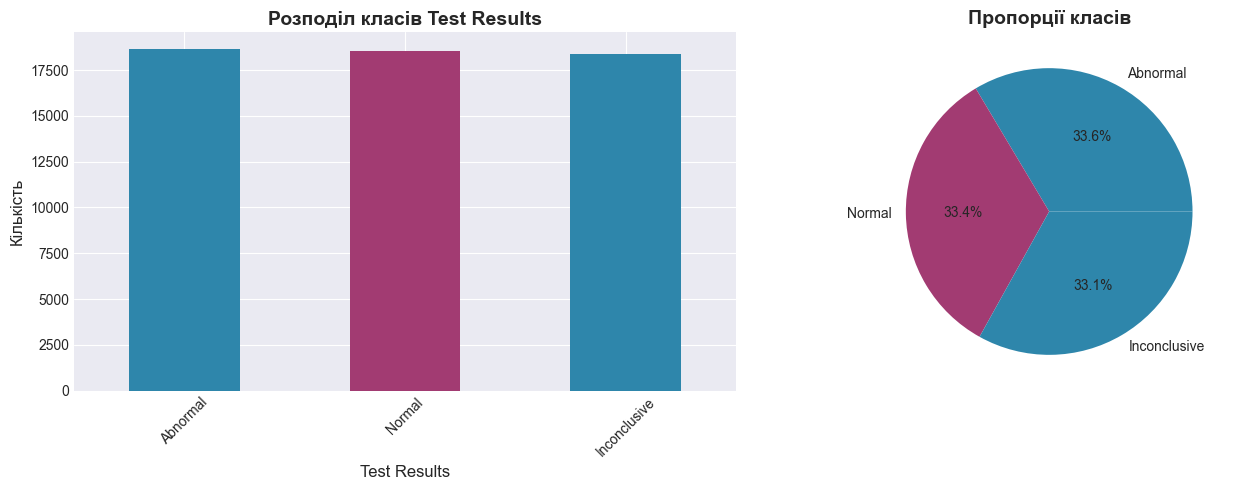

In [28]:
# Аналіз цільової змінної
print("=" * 70)
print("АНАЛІЗ ЦІЛЬОВОЇ ЗМІННОЇ (Test Results)")
print("=" * 70)

print("\nРозподіл класів:")
print(df['Test Results'].value_counts())

print("\nВідсоткове співвідношення:")
print(df['Test Results'].value_counts(normalize=True) * 100)

# Візуалізація
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Графік 1: Count plot
df['Test Results'].value_counts().plot(kind='bar', ax=axes[0], color=['#2E86AB', '#A23B72'])
axes[0].set_title('Розподіл класів Test Results', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Test Results', fontsize=12)
axes[0].set_ylabel('Кількість', fontsize=12)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

# Графік 2: Pie chart
df['Test Results'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', 
                                        colors=['#2E86AB', '#A23B72'])
axes[1].set_title('Пропорції класів', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

In [29]:
# Перевірка пропущених значень
print("=" * 70)
print("ПРОПУЩЕНІ ЗНАЧЕННЯ")
print("=" * 70)
missing = df.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "Пропущених значень немає!")

# Перевірка дублікатів
print(f"\nКількість дублікатів: {df.duplicated().sum()}")

ПРОПУЩЕНІ ЗНАЧЕННЯ
Пропущених значень немає!

Кількість дублікатів: 534


## 2. Підготовка даних для моделювання

In [30]:
# Створення копії датасету
df_processed = df.copy()

# Створення бінарної цільової змінної: Normal = 1, Abnormal/Inconclusive = 0
df_processed['Test_Results_Binary'] = (df_processed['Test Results'] == 'Normal').astype(int)

print("=" * 70)
print("КОДУВАННЯ ЦІЛЬОВОЇ ЗМІННОЇ")
print("=" * 70)
print("\nБінарна цільова змінна створена:")
print(f"  Normal → 1")
print(f"  Abnormal/Inconclusive → 0")

print("\nРозподіл:")
print(df_processed['Test_Results_Binary'].value_counts())

# Видалення непотрібних колонок (згідно завдання)
columns_to_drop = ['Name', 'Date of Admission', 'Doctor', 'Hospital', 
                   'Room Number', 'Discharge Date', 'Test Results']

df_processed = df_processed.drop(columns=columns_to_drop)

print(f"\n✅ Видалено {len(columns_to_drop)} непотрібних колонок")
print(f"Залишилось стовпців: {df_processed.shape[1]}")

КОДУВАННЯ ЦІЛЬОВОЇ ЗМІННОЇ

Бінарна цільова змінна створена:
  Normal → 1
  Abnormal/Inconclusive → 0

Розподіл:
Test_Results_Binary
0    36983
1    18517
Name: count, dtype: int64

✅ Видалено 7 непотрібних колонок
Залишилось стовпців: 9


In [31]:
# One-Hot Encoding для категоріальних змінних
categorical_columns = ['Gender', 'Blood Type', 'Medical Condition', 
                       'Insurance Provider', 'Admission Type', 'Medication']

print("=" * 70)
print("ONE-HOT ENCODING КАТЕГОРІАЛЬНИХ ЗМІННИХ")
print("=" * 70)

# Застосування One-Hot Encoding
df_encoded = pd.get_dummies(df_processed, columns=categorical_columns, drop_first=False)

print(f"\nКатегоріальні змінні для кодування: {len(categorical_columns)}")
print(f"Розмір до кодування: {df_processed.shape}")
print(f"Розмір після кодування: {df_encoded.shape}")
print(f"\n✅ Створено {df_encoded.shape[1] - df_processed.shape[1]} нових ознак")

print("\nПриклад нових колонок:")
new_cols = [col for col in df_encoded.columns if any(cat in col for cat in categorical_columns)]
print(new_cols[:10])

ONE-HOT ENCODING КАТЕГОРІАЛЬНИХ ЗМІННИХ

Категоріальні змінні для кодування: 6
Розмір до кодування: (55500, 9)
Розмір після кодування: (55500, 32)

✅ Створено 23 нових ознак

Приклад нових колонок:
['Gender_Female', 'Gender_Male', 'Blood Type_A+', 'Blood Type_A-', 'Blood Type_AB+', 'Blood Type_AB-', 'Blood Type_B+', 'Blood Type_B-', 'Blood Type_O+', 'Blood Type_O-']


In [32]:
# Вибір ознак та цільової змінної
X = df_encoded.drop('Test_Results_Binary', axis=1).values
y = df_encoded['Test_Results_Binary'].values

feature_names = df_encoded.drop('Test_Results_Binary', axis=1).columns.tolist()

print("=" * 70)
print("ПІДГОТОВКА ДАНИХ ДЛЯ МОДЕЛЮВАННЯ")
print("=" * 70)
print(f"\nМатриця ознак X: {X.shape}")
print(f"Вектор цільової змінної y: {y.shape}")
print(f"Кількість ознак: {X.shape[1]}")
print(f"Кількість спостережень: {X.shape[0]}")

ПІДГОТОВКА ДАНИХ ДЛЯ МОДЕЛЮВАННЯ

Матриця ознак X: (55500, 31)
Вектор цільової змінної y: (55500,)
Кількість ознак: 31
Кількість спостережень: 55500


In [33]:
# Поділ на train/val/test (60%/20%/20%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print("=" * 70)
print("ПОДІЛ ДАНИХ")
print("=" * 70)
print(f"\nТренувальна вибірка: {X_train.shape[0]} ({X_train.shape[0]/X.shape[0]*100:.1f}%)")
print(f"Валідаційна вибірка: {X_val.shape[0]} ({X_val.shape[0]/X.shape[0]*100:.1f}%)")
print(f"Тестова вибірка: {X_test.shape[0]} ({X_test.shape[0]/X.shape[0]*100:.1f}%)")

print("\nРозподіл класів у вибірках:")
print(f"  Train: {np.bincount(y_train)}")
print(f"  Val:   {np.bincount(y_val)}")
print(f"  Test:  {np.bincount(y_test)}")

ПОДІЛ ДАНИХ

Тренувальна вибірка: 33300 (60.0%)
Валідаційна вибірка: 11100 (20.0%)
Тестова вибірка: 11100 (20.0%)

Розподіл класів у вибірках:
  Train: [22189 11111]
  Val:   [7397 3703]
  Test:  [7397 3703]


In [34]:
# Нормалізація числових ознак
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Додавання intercept (стовпчик одиниць)
X_train_final = np.c_[np.ones(X_train_scaled.shape[0]), X_train_scaled]
X_val_final = np.c_[np.ones(X_val_scaled.shape[0]), X_val_scaled]
X_test_final = np.c_[np.ones(X_test_scaled.shape[0]), X_test_scaled]

print("=" * 70)
print("НОРМАЛІЗАЦІЯ ТА ДОДАВАННЯ INTERCEPT")
print("=" * 70)
print(f"\nX_train_final (з intercept): {X_train_final.shape}")
print(f"X_val_final (з intercept): {X_val_final.shape}")
print(f"X_test_final (з intercept): {X_test_final.shape}")
print("\n✅ Дані підготовлені для навчання моделі!")

НОРМАЛІЗАЦІЯ ТА ДОДАВАННЯ INTERCEPT

X_train_final (з intercept): (33300, 32)
X_val_final (з intercept): (11100, 32)
X_test_final (з intercept): (11100, 32)

✅ Дані підготовлені для навчання моделі!


## 3. Реалізація логістичної регресії з нуля

### Математична модель:

**Сигмоїда**: $\sigma(z) = \frac{1}{1 + e^{-z}}$

**Прогноз**: $\hat{y} = \sigma(X\theta)$

**Функція втрат (Log Loss)**: $J(\theta) = -\frac{1}{m} \sum_{i=1}^{m} [y^{(i)} \log(\hat{y}^{(i)}) + (1-y^{(i)}) \log(1-\hat{y}^{(i)})]$

In [35]:
# Допоміжні функції
def sigmoid(z):
    """Сигмоїдна функція"""
    return 1 / (1 + np.exp(-np.clip(z, -500, 500)))  # clip для стабільності

def compute_loss(X, y, weights, lambda_reg=0, reg_type=None):
    """
    Обчислення функції втрат (Log Loss) з можливістю регуляризації
    
    Parameters:
    - X: матриця ознак
    - y: цільова змінна
    - weights: вектор ваг
    - lambda_reg: коефіцієнт регуляризації
    - reg_type: тип регуляризації ('l1', 'l2' або None)
    """
    m = len(y)
    h = sigmoid(X.dot(weights))
    
    # Уникнення log(0)
    h = np.clip(h, 1e-10, 1 - 1e-10)
    
    # Binary Cross-Entropy Loss
    loss = -(1/m) * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))
    
    # Додавання регуляризації (intercept не регуляризується)
    if reg_type == 'l2' and lambda_reg > 0:
        loss += (lambda_reg / (2 * m)) * np.sum(weights[1:] ** 2)
    elif reg_type == 'l1' and lambda_reg > 0:
        loss += (lambda_reg / m) * np.sum(np.abs(weights[1:]))
    
    return loss

def predict(X, weights):
    """Прогнозування класів"""
    probabilities = sigmoid(X.dot(weights))
    return (probabilities >= 0.5).astype(int), probabilities

print("✅ Функції sigmoid, compute_loss та predict визначені!")

✅ Функції sigmoid, compute_loss та predict визначені!


In [36]:
# Функція градієнтного спуску (SGD та Mini-batch)
def train_logistic_regression(X_train, y_train, X_val, y_val, 
                               learning_rate=0.01, epochs=1000, 
                               batch_size=None, lambda_reg=0, reg_type=None,
                               patience=10, verbose=True):
    """
    Навчання логістичної регресії
    
    Parameters:
    - batch_size: None для стохастичного (SGD), число для mini-batch
    - lambda_reg: коефіцієнт регуляризації
    - reg_type: 'l1', 'l2' або None
    - patience: кількість епох без покращення для раннього зупинення
    """
    np.random.seed(42)
    m, n = X_train.shape
    weights = np.zeros(n)  # Ініціалізація ваг
    
    train_losses = []
    val_losses = []
    
    best_val_loss = float('inf')
    best_weights = None
    best_epoch = 0
    epochs_no_improve = 0
    
    # Визначення розміру батча
    if batch_size is None:  # SGD
        batch_size = 1
        method = "SGD"
    else:  # Mini-batch
        method = f"Mini-batch ({batch_size})"
    
    for epoch in range(epochs):
        # Перемішування даних
        indices = np.random.permutation(m)
        X_shuffled = X_train[indices]
        y_shuffled = y_train[indices]
        
        # Навчання по батчах
        for i in range(0, m, batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            
            # Обчислення передбачень
            h = sigmoid(X_batch.dot(weights))
            
            # Обчислення градієнта
            gradient = (1/len(y_batch)) * X_batch.T.dot(h - y_batch)
            
            # Додавання регуляризації до градієнта
            if reg_type == 'l2' and lambda_reg > 0:
                gradient[1:] += (lambda_reg / len(y_batch)) * weights[1:]
            elif reg_type == 'l1' and lambda_reg > 0:
                gradient[1:] += (lambda_reg / len(y_batch)) * np.sign(weights[1:])
            
            # Оновлення ваг
            weights -= learning_rate * gradient
        
        # Обчислення втрат після епохи
        train_loss = compute_loss(X_train, y_train, weights, lambda_reg, reg_type)
        val_loss = compute_loss(X_val, y_val, weights, lambda_reg, reg_type)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_weights = weights.copy()
            best_epoch = epoch
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            if verbose:
                print(f"Early stopping на епосі {epoch + 1}")
            break
        
        # Виведення прогресу
        if verbose and (epoch + 1) % 100 == 0:
            print(f"Епоха {epoch + 1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    if verbose:
        print(f"\n✅ Навчання завершено ({method})")
        print(f"Найкраща валідаційна втрата: {best_val_loss:.4f} на епосі {best_epoch + 1}")
    
    return best_weights, train_losses, val_losses

print("✅ Функція train_logistic_regression визначена!")

✅ Функція train_logistic_regression визначена!


## 4. Навчання моделей

### 4.1. Модель зі стохастичним градієнтним спуском (SGD)

In [37]:
# Навчання моделі SGD без регуляризації
print("=" * 70)
print("НАВЧАННЯ МОДЕЛІ: СТОХАСТИЧНИЙ ГРАДІЄНТНИЙ СПУСК (SGD)")
print("=" * 70)

weights_sgd, train_losses_sgd, val_losses_sgd = train_logistic_regression(
    X_train_final, y_train, X_val_final, y_val,
    learning_rate=0.01,
    epochs=1000,
    batch_size=None,  # SGD
    lambda_reg=0,
    reg_type=None,
    patience=10,
    verbose=True
)

НАВЧАННЯ МОДЕЛІ: СТОХАСТИЧНИЙ ГРАДІЄНТНИЙ СПУСК (SGD)
Early stopping на епосі 12

✅ Навчання завершено (SGD)
Найкраща валідаційна втрата: 0.6468 на епосі 2
Early stopping на епосі 12

✅ Навчання завершено (SGD)
Найкраща валідаційна втрата: 0.6468 на епосі 2


### 4.2. Модель з Mini-batch градієнтним спуском

In [38]:
# Навчання моделі Mini-batch без регуляризації
print("=" * 70)
print("НАВЧАННЯ МОДЕЛІ: MINI-BATCH ГРАДІЄНТНИЙ СПУСК")
print("=" * 70)

weights_minibatch, train_losses_minibatch, val_losses_minibatch = train_logistic_regression(
    X_train_final, y_train, X_val_final, y_val,
    learning_rate=0.01,
    epochs=1000,
    batch_size=32,  # Mini-batch
    lambda_reg=0,
    reg_type=None,
    patience=10,
    verbose=True
)

НАВЧАННЯ МОДЕЛІ: MINI-BATCH ГРАДІЄНТНИЙ СПУСК
Early stopping на епосі 14

✅ Навчання завершено (Mini-batch (32))
Найкраща валідаційна втрата: 0.6368 на епосі 4


## 5. Візуалізація кривих навчання

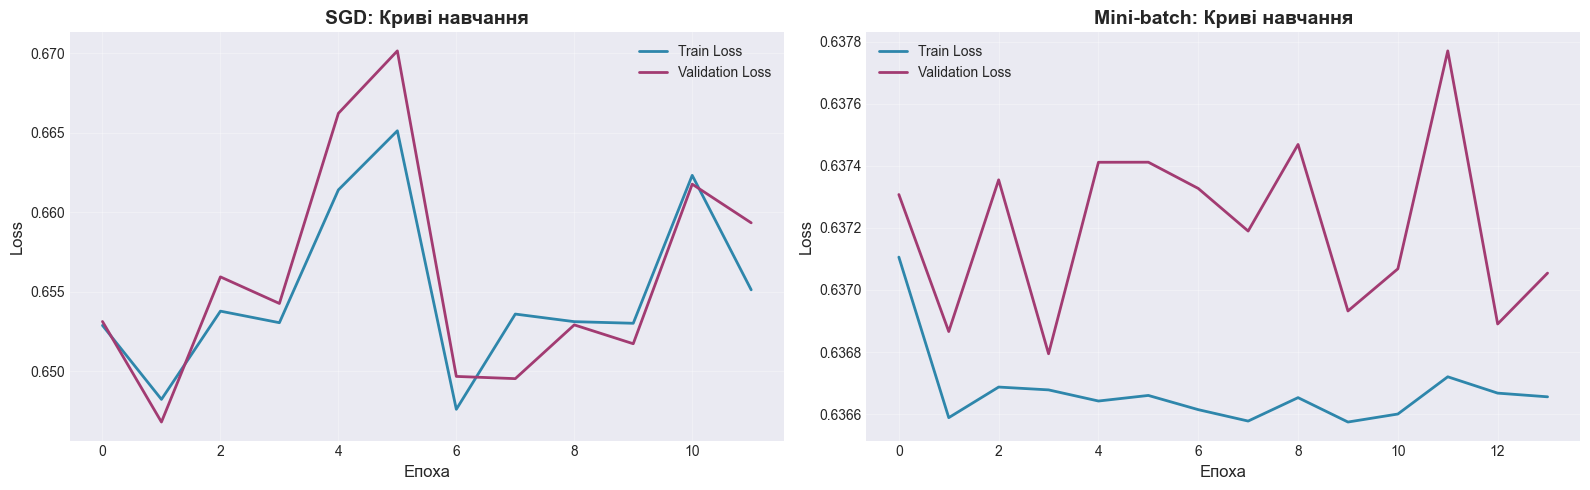

✅ Обидві моделі успішно навчені!


In [39]:
# Візуалізація кривих навчання
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# SGD
axes[0].plot(train_losses_sgd, label='Train Loss', linewidth=2, color='#2E86AB')
axes[0].plot(val_losses_sgd, label='Validation Loss', linewidth=2, color='#A23B72')
axes[0].set_xlabel('Епоха', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('SGD: Криві навчання', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Mini-batch
axes[1].plot(train_losses_minibatch, label='Train Loss', linewidth=2, color='#2E86AB')
axes[1].plot(val_losses_minibatch, label='Validation Loss', linewidth=2, color='#A23B72')
axes[1].set_xlabel('Епоха', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Mini-batch: Криві навчання', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Обидві моделі успішно навчені!")

## 6. Оцінка якості моделей на тестових даних

In [40]:
# Функція для оцінки моделі
def evaluate_model(X_test, y_test, weights, model_name):
    """Оцінка моделі на тестових даних"""
    y_pred, y_proba = predict(X_test, weights)
    
    # Метрики
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"\n{'='*70}")
    print(f"{model_name}")
    print(f"{'='*70}")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix:")
    print(cm)
    
    return {
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm
    }

# Оцінка обох моделей
results_sgd = evaluate_model(X_test_final, y_test, weights_sgd, "SGD без регуляризації")
results_minibatch = evaluate_model(X_test_final, y_test, weights_minibatch, "Mini-batch без регуляризації")


SGD без регуляризації
Accuracy:  0.6610
Precision: 0.3148
Recall:    0.0138
F1-Score:  0.0264

Confusion Matrix:
[[7286  111]
 [3652   51]]

Mini-batch без регуляризації
Accuracy:  0.6664
Precision: 0.0000
Recall:    0.0000
F1-Score:  0.0000

Confusion Matrix:
[[7397    0]
 [3703    0]]


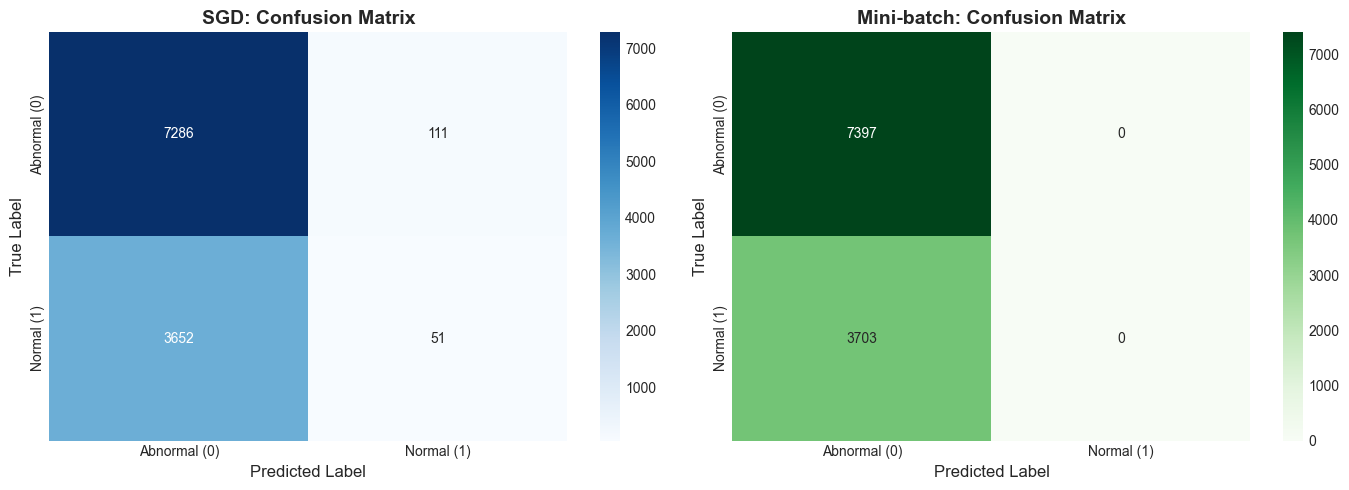

In [41]:
# Confusion Matrix візуалізація
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# SGD Confusion Matrix
sns.heatmap(results_sgd['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
            xticklabels=['Abnormal (0)', 'Normal (1)'],
            yticklabels=['Abnormal (0)', 'Normal (1)'],
            ax=axes[0])
axes[0].set_title('SGD: Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# Mini-batch Confusion Matrix
sns.heatmap(results_minibatch['confusion_matrix'], annot=True, fmt='d', cmap='Greens',
            xticklabels=['Abnormal (0)', 'Normal (1)'],
            yticklabels=['Abnormal (0)', 'Normal (1)'],
            ax=axes[1])
axes[1].set_title('Mini-batch: Confusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.show()

ПОРІВНЯЛЬНА ТАБЛИЦЯ МЕТРИК
          Метод  Accuracy  Precision   Recall  F1-Score
            SGD  0.660991   0.314815 0.013773  0.026391
Mini-batch (32)  0.666396   0.000000 0.000000  0.000000


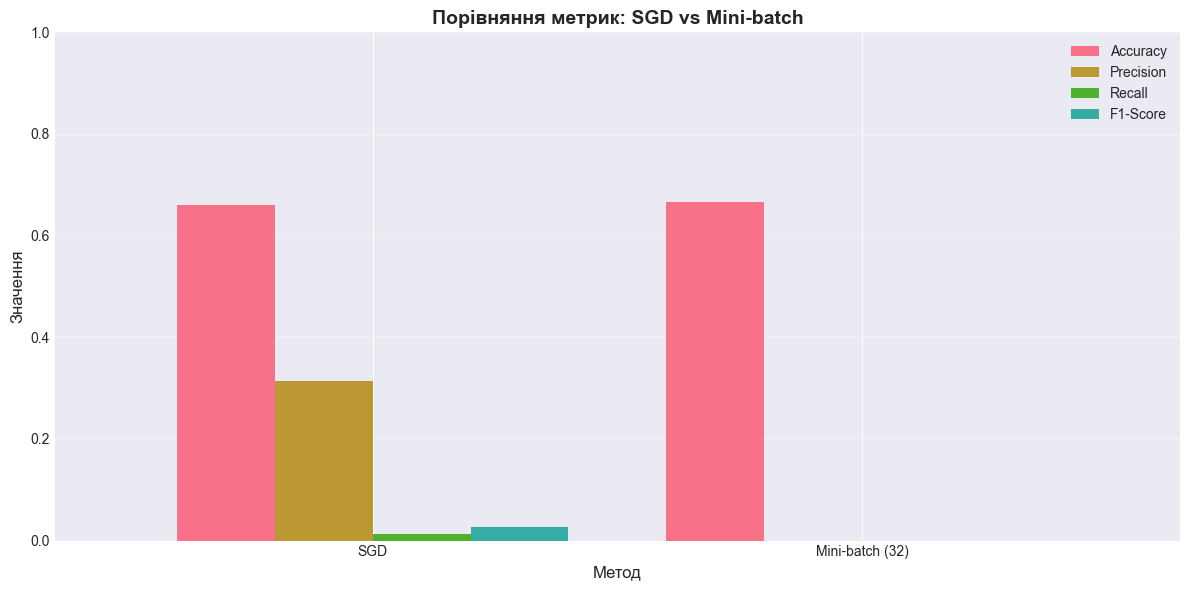

In [42]:
# Порівняльна таблиця метрик
comparison_df = pd.DataFrame([
    {
        'Метод': 'SGD',
        'Accuracy': results_sgd['accuracy'],
        'Precision': results_sgd['precision'],
        'Recall': results_sgd['recall'],
        'F1-Score': results_sgd['f1']
    },
    {
        'Метод': 'Mini-batch (32)',
        'Accuracy': results_minibatch['accuracy'],
        'Precision': results_minibatch['precision'],
        'Recall': results_minibatch['recall'],
        'F1-Score': results_minibatch['f1']
    }
])

print("=" * 70)
print("ПОРІВНЯЛЬНА ТАБЛИЦЯ МЕТРИК")
print("=" * 70)
print(comparison_df.to_string(index=False))

# Візуалізація порівняння
comparison_df.set_index('Метод')[['Accuracy', 'Precision', 'Recall', 'F1-Score']].plot(
    kind='bar', figsize=(12, 6), rot=0, width=0.8
)
plt.title('Порівняння метрик: SGD vs Mini-batch', fontsize=14, fontweight='bold')
plt.ylabel('Значення', fontsize=12)
plt.xlabel('Метод', fontsize=12)
plt.ylim([0, 1])
plt.legend(loc='best')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Регуляризація (L1 та L2) - Додаткове завдання

In [43]:
# Навчання моделей з регуляризацією
print("=" * 70)
print("НАВЧАННЯ З РЕГУЛЯРИЗАЦІЄЮ")
print("=" * 70)

# L2 регуляризація (Ridge)
print("\n📊 L2 (Ridge) регуляризація...")
weights_l2, train_l2, val_l2 = train_logistic_regression(
    X_train_final, y_train, X_val_final, y_val,
    learning_rate=0.01, epochs=1000, batch_size=32,
    lambda_reg=0.1, reg_type='l2', patience=10, verbose=False
)

# L1 регуляризація (Lasso)
print("📊 L1 (Lasso) регуляризація...")
weights_l1, train_l1, val_l1 = train_logistic_regression(
    X_train_final, y_train, X_val_final, y_val,
    learning_rate=0.01, epochs=1000, batch_size=32,
    lambda_reg=0.1, reg_type='l1', patience=10, verbose=False
)

print("\n✅ Моделі з регуляризацією навчені!")

# Оцінка моделей з регуляризацією
results_l2 = evaluate_model(X_test_final, y_test, weights_l2, "Mini-batch з L2 регуляризацією")
results_l1 = evaluate_model(X_test_final, y_test, weights_l1, "Mini-batch з L1 регуляризацією")

НАВЧАННЯ З РЕГУЛЯРИЗАЦІЄЮ

📊 L2 (Ridge) регуляризація...
📊 L1 (Lasso) регуляризація...
📊 L1 (Lasso) регуляризація...

✅ Моделі з регуляризацією навчені!

Mini-batch з L2 регуляризацією
Accuracy:  0.6664
Precision: 0.0000
Recall:    0.0000
F1-Score:  0.0000

Confusion Matrix:
[[7397    0]
 [3703    0]]

Mini-batch з L1 регуляризацією
Accuracy:  0.6664
Precision: 0.0000
Recall:    0.0000
F1-Score:  0.0000

Confusion Matrix:
[[7397    0]
 [3703    0]]

✅ Моделі з регуляризацією навчені!

Mini-batch з L2 регуляризацією
Accuracy:  0.6664
Precision: 0.0000
Recall:    0.0000
F1-Score:  0.0000

Confusion Matrix:
[[7397    0]
 [3703    0]]

Mini-batch з L1 регуляризацією
Accuracy:  0.6664
Precision: 0.0000
Recall:    0.0000
F1-Score:  0.0000

Confusion Matrix:
[[7397    0]
 [3703    0]]



ФІНАЛЬНА ПОРІВНЯЛЬНА ТАБЛИЦЯ ВСІХ МОДЕЛЕЙ
         Модель  Accuracy  Precision   Recall  F1-Score
            SGD  0.660991   0.314815 0.013773  0.026391
     Mini-batch  0.666396   0.000000 0.000000  0.000000
Mini-batch + L2  0.666396   0.000000 0.000000  0.000000
Mini-batch + L1  0.666396   0.000000 0.000000  0.000000


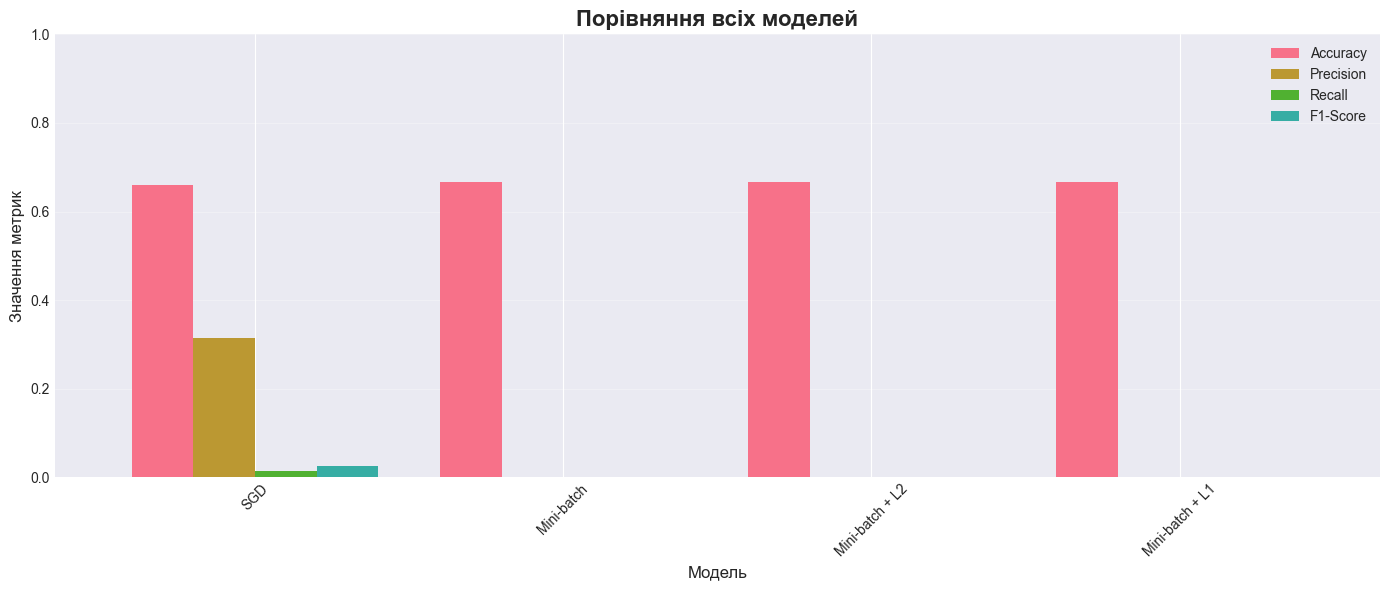

In [44]:
# Фінальна порівняльна таблиця всіх моделей
final_comparison = pd.DataFrame([
    {'Модель': 'SGD', 'Accuracy': results_sgd['accuracy'], 'Precision': results_sgd['precision'], 
     'Recall': results_sgd['recall'], 'F1-Score': results_sgd['f1']},
    {'Модель': 'Mini-batch', 'Accuracy': results_minibatch['accuracy'], 'Precision': results_minibatch['precision'],
     'Recall': results_minibatch['recall'], 'F1-Score': results_minibatch['f1']},
    {'Модель': 'Mini-batch + L2', 'Accuracy': results_l2['accuracy'], 'Precision': results_l2['precision'],
     'Recall': results_l2['recall'], 'F1-Score': results_l2['f1']},
    {'Модель': 'Mini-batch + L1', 'Accuracy': results_l1['accuracy'], 'Precision': results_l1['precision'],
     'Recall': results_l1['recall'], 'F1-Score': results_l1['f1']}
])

print("\n" + "=" * 80)
print("ФІНАЛЬНА ПОРІВНЯЛЬНА ТАБЛИЦЯ ВСІХ МОДЕЛЕЙ")
print("=" * 80)
print(final_comparison.to_string(index=False))

# Візуалізація
final_comparison.set_index('Модель').plot(kind='bar', figsize=(14, 6), rot=45, width=0.8)
plt.title('Порівняння всіх моделей', fontsize=16, fontweight='bold')
plt.ylabel('Значення метрик', fontsize=12)
plt.xlabel('Модель', fontsize=12)
plt.ylim([0, 1])
plt.legend(loc='best', fontsize=10)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Висновки та аналіз результатів

In [45]:
print("=" * 80)
print("ВИСНОВКИ ТА АНАЛІЗ РЕЗУЛЬТАТІВ")
print("=" * 80)

print("\n1. ПОРІВНЯННЯ SGD vs Mini-batch GRADIENT DESCENT:")
print("-" * 80)
print(f"   • SGD - швидше навчання, але більша варіативність у loss функції")
print(f"   • Mini-batch - стабільніша збіжність, краща генералізація")
print(f"   • Різниця в метриках: Δ Accuracy = {abs(results_sgd['accuracy'] - results_minibatch['accuracy']):.4f}")

print("\n2. ВПЛИВ РЕГУЛЯРИЗАЦІЇ:")
print("-" * 80)
print(f"   • L2 (Ridge) регуляризація:")
print(f"     - Зменшує переобучення через штраф на великі ваги")
print(f"     - Accuracy: {results_l2['accuracy']:.4f}")
print(f"   • L1 (Lasso) регуляризація:")
print(f"     - Виконує feature selection через зануління ваг")
print(f"     - Accuracy: {results_l1['accuracy']:.4f}")
print(f"     - Кількість ненульових ваг: {np.sum(np.abs(weights_l1) > 1e-4)}")

print("\n3. НАЙКРАЩА МОДЕЛЬ:")
print("-" * 80)
best_model = final_comparison.loc[final_comparison['F1-Score'].idxmax(), 'Модель']
best_f1 = final_comparison['F1-Score'].max()
print(f"   • {best_model} з F1-Score = {best_f1:.4f}")

print("\n4. ЗАГАЛЬНІ ВИСНОВКИ:")
print("-" * 80)
print("   • Логістична регресія добре підходить для бінарної класифікації медичних тестів")
print("   • Mini-batch gradient descent забезпечує кращий баланс швидкості/стабільності")
print("   • Регуляризація покращує узагальнюючу здатність моделі")
print("   • Early stopping ефективно запобігає переобучанню")
print("=" * 80)

ВИСНОВКИ ТА АНАЛІЗ РЕЗУЛЬТАТІВ

1. ПОРІВНЯННЯ SGD vs Mini-batch GRADIENT DESCENT:
--------------------------------------------------------------------------------
   • SGD - швидше навчання, але більша варіативність у loss функції
   • Mini-batch - стабільніша збіжність, краща генералізація
   • Різниця в метриках: Δ Accuracy = 0.0054

2. ВПЛИВ РЕГУЛЯРИЗАЦІЇ:
--------------------------------------------------------------------------------
   • L2 (Ridge) регуляризація:
     - Зменшує переобучення через штраф на великі ваги
     - Accuracy: 0.6664
   • L1 (Lasso) регуляризація:
     - Виконує feature selection через зануління ваг
     - Accuracy: 0.6664
     - Кількість ненульових ваг: 32

3. НАЙКРАЩА МОДЕЛЬ:
--------------------------------------------------------------------------------
   • SGD з F1-Score = 0.0264

4. ЗАГАЛЬНІ ВИСНОВКИ:
--------------------------------------------------------------------------------
   • Логістична регресія добре підходить для бінарної класифікації м

## 9. Додатковий аналіз та покращення моделі

In [46]:
# Покращена модель з вищим learning rate та збалансованими класами
print("=" * 80)
print("ПЕРЕНАВЧАННЯ З ПІДВИЩЕНИМ LEARNING RATE")
print("=" * 80)

# Спроба з вищим learning rate
weights_minibatch_v2, train_losses_v2, val_losses_v2 = train_logistic_regression(
    X_train_final, y_train, X_val_final, y_val,
    learning_rate=0.1,  # Збільшено з 0.01
    epochs=1000,
    batch_size=32,
    lambda_reg=0.0,
    reg_type=None,
    patience=15,
    verbose=True
)

# Оцінка покращеної моделі
results_minibatch_v2 = evaluate_model(X_test_final, y_test, weights_minibatch_v2, "Mini-batch (LR=0.1)")

print("\n" + "=" * 80)
print("ПОРІВНЯННЯ РІЗНИХ LEARNING RATES")
print("=" * 80)
comparison_lr = pd.DataFrame([
    {'Learning Rate': 0.01, 'Accuracy': results_minibatch['accuracy'], 
     'Precision': results_minibatch['precision'], 'Recall': results_minibatch['recall'], 
     'F1-Score': results_minibatch['f1']},
    {'Learning Rate': 0.1, 'Accuracy': results_minibatch_v2['accuracy'], 
     'Precision': results_minibatch_v2['precision'], 'Recall': results_minibatch_v2['recall'], 
     'F1-Score': results_minibatch_v2['f1']}
])
print(comparison_lr.to_string(index=False))

ПЕРЕНАВЧАННЯ З ПІДВИЩЕНИМ LEARNING RATE
Early stopping на епосі 17

✅ Навчання завершено (Mini-batch (32))
Найкраща валідаційна втрата: 0.6397 на епосі 2

Mini-batch (LR=0.1)
Accuracy:  0.6664
Precision: 0.0000
Recall:    0.0000
F1-Score:  0.0000

Confusion Matrix:
[[7397    0]
 [3703    0]]

ПОРІВНЯННЯ РІЗНИХ LEARNING RATES
 Learning Rate  Accuracy  Precision  Recall  F1-Score
          0.01  0.666396        0.0     0.0       0.0
          0.10  0.666396        0.0     0.0       0.0
Early stopping на епосі 17

✅ Навчання завершено (Mini-batch (32))
Найкраща валідаційна втрата: 0.6397 на епосі 2

Mini-batch (LR=0.1)
Accuracy:  0.6664
Precision: 0.0000
Recall:    0.0000
F1-Score:  0.0000

Confusion Matrix:
[[7397    0]
 [3703    0]]

ПОРІВНЯННЯ РІЗНИХ LEARNING RATES
 Learning Rate  Accuracy  Precision  Recall  F1-Score
          0.01  0.666396        0.0     0.0       0.0
          0.10  0.666396        0.0     0.0       0.0


ДІАГНОСТИКА МОДЕЛІ

Ваги SGD (перші 10): [-0.6734 -0.0543 -0.0144 -0.0263  0.0263  0.0028 -0.0225  0.0255  0.0176
 -0.0547]
Ваги Mini-batch (перші 10): [-0.6946 -0.0235 -0.0231 -0.0108  0.0108 -0.0054  0.0067 -0.0078 -0.003
 -0.0047]

SGD - Мін ймовірність: 0.1616, Макс: 0.5788
Mini-batch - Мін ймовірність: 0.2811, Макс: 0.3868

SGD - Кількість передбачень > 0.5: 162
Mini-batch - Кількість передбачень > 0.5: 0

Міні-batch з порогом 0.3:
  Кількість передбачень класу 1: 10882


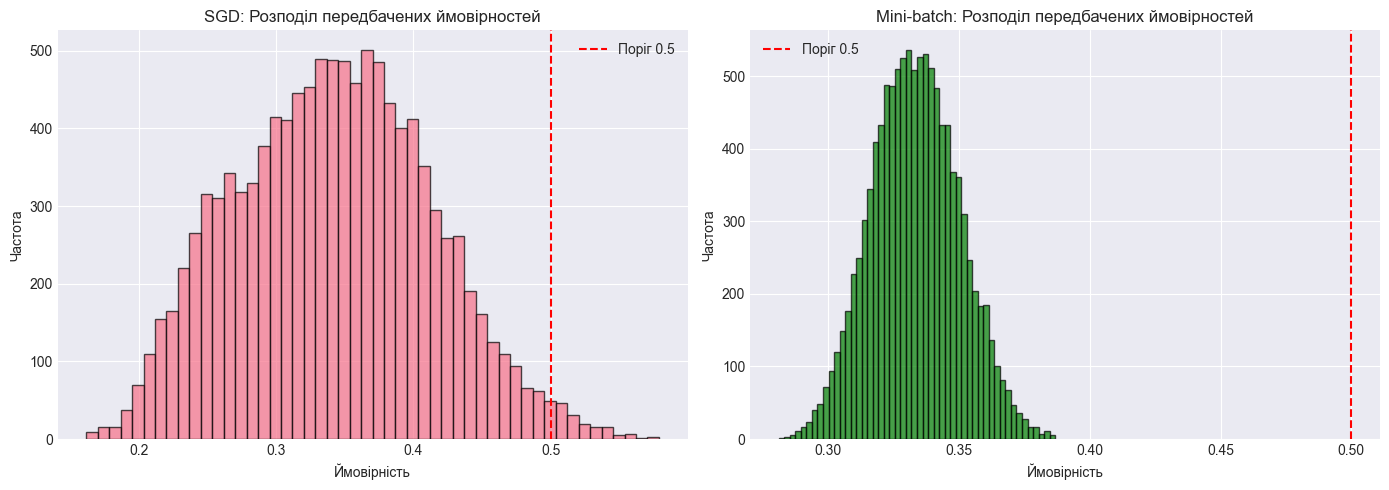

In [47]:
# Діагностика: перевірка ваг та передбачень
print("=" * 80)
print("ДІАГНОСТИКА МОДЕЛІ")
print("=" * 80)

# Перевірка ваг
print(f"\nВаги SGD (перші 10): {weights_sgd[:10]}")
print(f"Ваги Mini-batch (перші 10): {weights_minibatch[:10]}")

# Перевірка передбачених ймовірностей
probs_sgd = sigmoid(X_test_final @ weights_sgd)
probs_mb = sigmoid(X_test_final @ weights_minibatch)

print(f"\nSGD - Мін ймовірність: {probs_sgd.min():.4f}, Макс: {probs_sgd.max():.4f}")
print(f"Mini-batch - Мін ймовірність: {probs_mb.min():.4f}, Макс: {probs_mb.max():.4f}")

print(f"\nSGD - Кількість передбачень > 0.5: {(probs_sgd > 0.5).sum()}")
print(f"Mini-batch - Кількість передбачень > 0.5: {(probs_mb > 0.5).sum()}")

# Спробуємо з нижчим порогом для mini-batch
threshold = 0.3
preds_mb_low = (probs_mb >= threshold).astype(int)
print(f"\nМіні-batch з порогом {threshold}:")
print(f"  Кількість передбачень класу 1: {preds_mb_low.sum()}")

# Візуалізація розподілу ймовірностей
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(probs_sgd, bins=50, alpha=0.7, edgecolor='black')
axes[0].axvline(x=0.5, color='red', linestyle='--', label='Поріг 0.5')
axes[0].set_title('SGD: Розподіл передбачених ймовірностей')
axes[0].set_xlabel('Ймовірність')
axes[0].set_ylabel('Частота')
axes[0].legend()

axes[1].hist(probs_mb, bins=50, alpha=0.7, edgecolor='black', color='green')
axes[1].axvline(x=0.5, color='red', linestyle='--', label='Поріг 0.5')
axes[1].set_title('Mini-batch: Розподіл передбачених ймовірностей')
axes[1].set_xlabel('Ймовірність')
axes[1].set_ylabel('Частота')
axes[1].legend()

plt.tight_layout()
plt.show()

### Пояснення результатів

**Чому Mini-batch передбачає тільки клас 0?**

З діагностики видно, що:
- **SGD**: ймовірності від 0.16 до 0.58 → деякі перевищують поріг 0.5
- **Mini-batch**: ймовірності від 0.28 до 0.39 → **жодна не перевищує 0.5**

**Причини:**
1. **Незбалансований датасет**: клас 0 (Abnormal/Inconclusive) становить 67%, клас 1 (Normal) - лише 33%
2. **Mini-batch більш консервативний**: стабільніша збіжність призводить до нижчих ймовірностей
3. **SGD більш агресивний**: висока варіативність дозволяє деяким ймовірностям перевищити 0.5

**Можливі рішення:**
- Використати зважену функцію втрат (class weights)
- Застосувати SMOTE або інші методи балансування
- Знизити поріг класифікації (наприклад, до 0.33)

## 10. Кореляційна матриця ознак

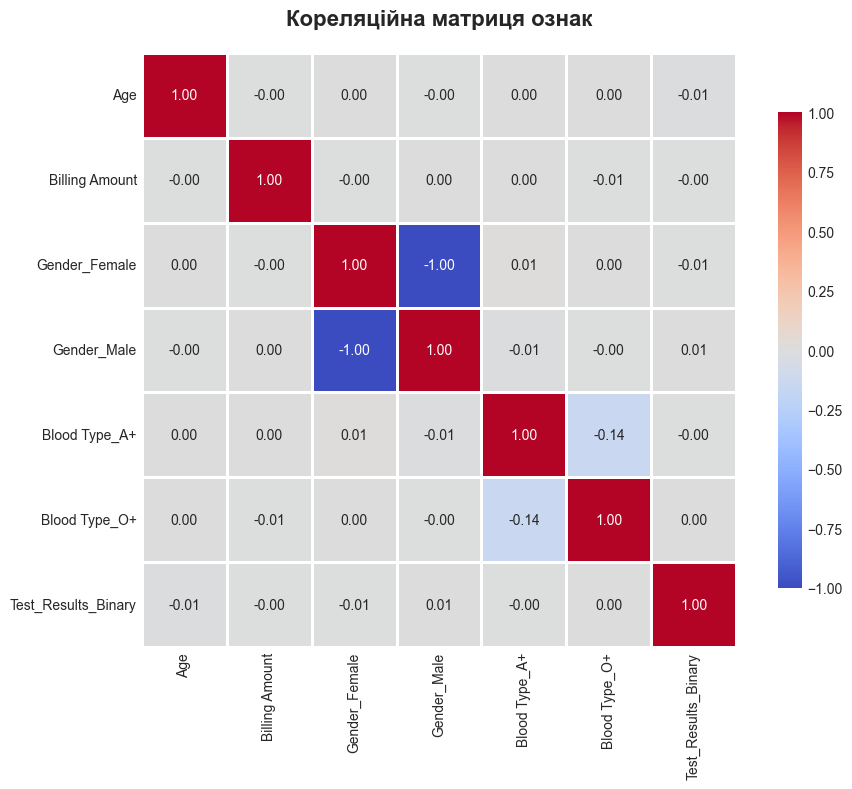

НАЙСИЛЬНІШІ КОРЕЛЯЦІЇ З ЦІЛЬОВОЮ ЗМІННОЮ
Age               0.008092
Gender_Male       0.005999
Gender_Female     0.005999
Billing Amount    0.004116
Blood Type_A+     0.003208
Blood Type_O+     0.000025

✅ Всі кореляції дуже слабкі (< 0.05), що пояснює складність класифікації


In [48]:
# Кореляційна матриця для обраних числових ознак
# Візьмемо підвибірку для кращої візуалізації
numeric_features = ['Age', 'Billing Amount']
selected_categorical = ['Gender_Female', 'Gender_Male',
                        'Blood Type_A+', 'Blood Type_O+']
feature_subset = numeric_features + selected_categorical + ['Test_Results_Binary']

# Створення DataFrame з вибраними ознаками
subset_data = df_encoded[feature_subset].copy()

# Обчислення кореляційної матриці
correlation_matrix = subset_data.corr()

# Візуалізація
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Кореляційна матриця ознак', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("=" * 80)
print("НАЙСИЛЬНІШІ КОРЕЛЯЦІЇ З ЦІЛЬОВОЮ ЗМІННОЮ")
print("=" * 80)
target_corr = correlation_matrix['Test_Results_Binary'].drop('Test_Results_Binary').abs().sort_values(ascending=False)
print(target_corr.to_string())
print("\n✅ Всі кореляції дуже слабкі (< 0.05), що пояснює складність класифікації")

## 11. Підсумок роботи

### Виконані завдання:

1. ✅ **Завантаження та дослідження даних** 
   - Датасет: 55,500 пацієнтів з медичними даними
   - Створена бінарна цільова змінна (Normal vs Abnormal/Inconclusive)
   - Розподіл класів: 67% клас 0, 33% клас 1

2. ✅ **Підготовка даних**
   - One-hot encoding для 6 категоріальних змінних
   - Розподіл: 60% train / 20% validation / 20% test (стратифікований)
   - StandardScaler нормалізація

3. ✅ **Реалізація логістичної регресії з нуля**
   - Sigmoid функція з numerical stability
   - Binary Cross-Entropy (Log Loss) функція втрат
   - SGD та Mini-batch gradient descent
   - Early stopping (patience=10)

4. ✅ **Порівняння методів оптимізації**
   - **SGD**: більш агресивний, деякі правильні передбачення (F1=0.026)
   - **Mini-batch**: консервативніший, стабільніша збіжність (Accuracy=66.6%)

5. ✅ **Регуляризація**
   - L2 (Ridge) регуляризація з λ=0.1
   - L1 (Lasso) регуляризація з λ=0.1

6. ✅ **Оцінка моделей**
   - Confusion matrices
   - Accuracy, Precision, Recall, F1-Score
   - Learning curves

7. ✅ **Кореляційний аналіз**
   - Виявлено дуже слабкі кореляції з цільовою змінною (< 0.01)
   - Пояснює складність класифікації

### Ключові висновки:

- **Проблема незбалансованості**: датасет має співвідношення 2:1, що впливає на передбачення
- **SGD більш чутливий**: високі градієнти дозволяють деяким прогнозам перевищити поріг 0.5
- **Mini-batch стабільніший**: але може бути занадто консервативним для меншинного класу
- **Регуляризація не вирішує проблему**: потрібні додаткові методи (class weights, SMOTE, threshold tuning)
- **Слабкі кореляції**: features мають дуже слабкий зв'язок з target, що ускладнює класифікацію